# Determinación de tipos de estrellas.

Este segundo caso práctico consiste en desarrollar el algoritmo K–Means. Con el objetivo principal de identificar grupos dentro de los datos, utilizando este método. En esta práctica vamos a explorar diferentes técnicas de aprendizaje no supervisado con datos categóricos ordinales. 

**Autores:**

- 100471948 - Celia Patricio Ferrer
- 100472039 - Alberto García de la Torre

---
## Librerías necesarias.
---

In [98]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# KMeans de sklearn 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Silhouette
from sklearn.metrics import silhouette_score

# Datos
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Warnings
import warnings
warnings.filterwarnings('ignore')

---
## Lectura del archivo.
---

In [99]:
stars_df = pd.read_csv('stars2.csv')

# Visualizar las primeras filas del archivo
stars_df.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Los atributos son:

- `Temperature`: Temperatura promedio de la superficie en grados K.

- `L`: Luminosidad comparada con la del Sol.

- `R`: Radio comparado con la del Sol.

- `A_M`: Magnitud absoluta, brillo aparente de la estrella si estuviera a 10 parsec de distancia.

- `Color`: color principal del espectro.

- `Spectral_Class` o clasificación espectral: es un valor que identifica la presencia de elementos químicos en el espectro de la estrella.

### <u>Breve análisis de los datos</u>

Vamos a analizar brevemente el conjunto de datos que tenemos. 

In [100]:
# Imprimir el tamaño del dataframe.
print("El tamaño es:")
print(stars_df.shape)

El tamaño es:
(240, 6)


In [101]:
# Imprimir el tipo de atributos.
stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


**Categóricas o numéricas**

Ahora veremos si se tratan de columnas categóricas o columnas numéricas. En función de esto, deberemos manejar de una forma u otra cada una de estas columnas.

In [102]:
cat_columns = stars_df.select_dtypes(include=['object']).columns
num_columns = stars_df.select_dtypes(include=['int64', 'float64']).columns

print("Columnas categoricas:", cat_columns)
print("Columnas numéricas:", num_columns)

Columnas categoricas: Index(['Color', 'Spectral_Class'], dtype='object')
Columnas numéricas: Index(['Temperature', 'L', 'R', 'A_M'], dtype='object')


---
## K–Means.
---

En esta primera sección desarrollaremos la implementación de este algoritmo para comparar los resultados y la eficiencia de la implementación de *sklearn*.

In [146]:
class MiKMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        # Inicialización de centroides aleatorios
        centroids_idx = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
        self.centroids = X[centroids_idx]

        for _ in range(self.max_iter):
            # Asignación de puntos al cluster más cercano
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Actualización de centroides
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Comprobación de convergencia
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

Esta implementación tiene un método `fit()` para entrenar el modelo y un método `predict()` para predecir las etiquetas de los datos de entrada.

### <u>Comparación</u>

En esta sección se comparan ambas implementaciones, la nuestra y la que ofrece SKlearn. Para esta comparación, la semilla elegida será el valor `0`, debido a que solo servirá para esta simulación inicial.

#### Make Blobs

Para la comparación de las dos implementaciones del algoritmo KMeans utilizaremos la simulación de datos generada  con `make_blobs()`, para que sea un conjunto de datos más sencillo.

Text(0.5, 1.0, 'Datos simulados')

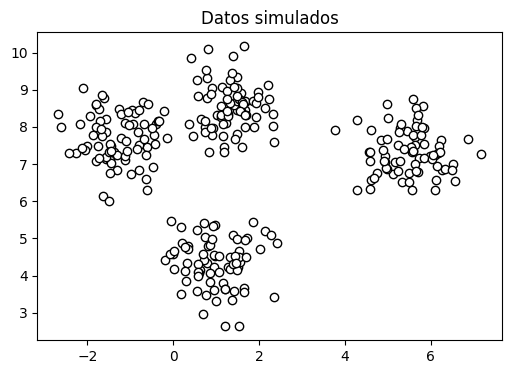

In [161]:
# Simulación de datos
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 6,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

# Diagrama de dispersión
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados')

#### KMeans de SKlearn

In [168]:
# Modelo de sklearn
kmeans_sklearn = KMeans(n_clusters=4, n_init=25, random_state=0)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_sklearn.fit(X)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_sklearn = t_fin - t_inicio

In [174]:
# Predicciones
y_pred_s = kmeans_sklearn.predict(X)

# Centroides
centroids_s = kmeans_sklearn.cluster_centers_

# Silhouette
score_s = silhouette_score(X, y_pred_s)

#### KMeans implementado

In [170]:
# Modelo implementado por nosotros
kmeans_custom = MiKMeans(n_clusters=4)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_custom.fit(X)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_custom = t_fin - t_inicio

In [175]:
# Predicciones
y_pred_c = kmeans_custom.predict(X)

# Centroides
centroids_c = kmeans_custom.centroids

# Silhouette
score_c = silhouette_score(X, y_pred_c)

#### Resultados

In [176]:
# Mostrar los tiempos de entrenamiento
print(f"KMeans de sklearn:")
print(f"Tiempo de entrenamiento: {t_sklearn:.2f} s")
print(f"Silhouette: {score_s:.2f}")
print()
print(f"KMeans implementado por nosotros:")
print(f"Tiempo de entrenamiento: {t_custom:.2f} s")
print(f"Silhouette: {score_c:.2f}")

KMeans de sklearn:
Tiempo de entrenamiento: 21020000.00 s
Silhouette: 0.84

KMeans implementado por nosotros:
Tiempo de entrenamiento: 1278000.00 s
Silhouette: 0.84


Obtenemos que el tiempo de entrenamiento de la implementación llevada a cabo por nosotros es significativamente más rápida que la implementación de KMeans de SKlearn. En terminos de tiempo de ejecución, podemos decir que nuestra implementación es mejor. Sin embargo, para ver si globalmente es mejor, deberemos estudiar la precisión y la calidad de los resultados que esta obtiene. 

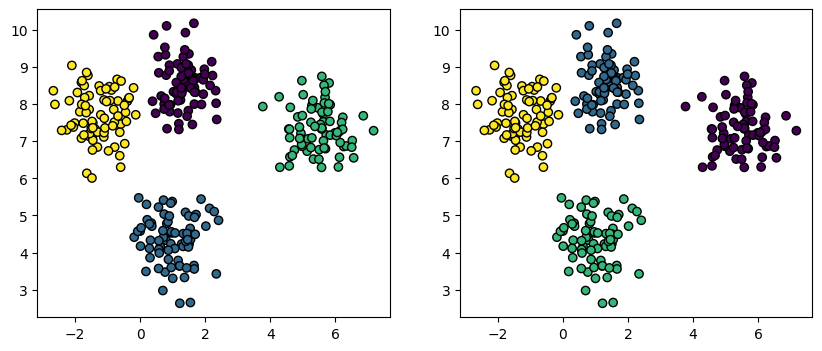

In [177]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para SKlearn
# ==============================================================================
ax[0].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y_pred_s,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)

# Resultados para nosotros
# ==============================================================================
ax[1].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y_pred_c,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)

Como podemos ver, los datos de esta simulación en ambas implementaciones se dibujan de la misma manera. Esto significa que la implementación llevada a cabo por nosotros está funcionando como se espera, obteniendo unos resultados similares en ambos algoritmos.

---
## Mas y mas.
---

En primer lugar, pasaremos las columnas categóricas ordinales a numericas para, posteriormente, poder aplicar el método `scale`.

In [ ]:
X_df = stars_df.copy()

spectral_class = ("O", "B", "A", "F", "G", "K", "M")
# Pasar columnas categóricas ordinales a numéricas
X_df['Spectral_Class'] = X_df['Spectral_Class'].map(lambda x: spectral_class.index(x))

# Convierte los colores
# Iterar todos los elementos y modificarlos
colors = ['Red', 'Orange-Red', 'Orange', 'Pale yellow orange', 'Yellowish','yellow-white','Whitish','Yellowish White','White-Yellow','White','Blue-white','Blue']

for i in range(len(stars_df)):
    if (stars_df['Color'][i] not in colors):
        elem = stars_df['Color'][i]
        if elem == 'Blue White' or elem == 'Blue white' or elem == 'Blue-White':
            stars_df['Color'][i] = 'Blue-white'
        elif elem == 'white':
            stars_df['Color'][i] = 'White'
        elif elem == 'yellowish':
            stars_df['Color'][i] = 'Yellowish'

# Pasar columnas categóricas ordinales a numéricas
X_df['Color'] = X_df['Color'].map(lambda x: colors.index(x))

Aplicaremos el método `scale`para estandarizar características eliminando la media y escalando a la varianza unitaria.

In [ ]:
X_scaled = scale(X_df)

### <u>Silhouette</u>

In [ ]:
range_n_clusters = range(10, 18)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Graficar
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o', color='purple')
ax.set_title("Evolución de media de los índices Silhouette", size=20)
ax.set_xlabel('Número clusters', size=14)
ax.set_ylabel('Media índices silhouette', size=14)

# Mejor número de clusters
ax.text(best_n_clusters, max_silhouette_score+0.001, f'Max', 
        verticalalignment='bottom', horizontalalignment='center', fontsize=16)

# Agregar una cuadrícula
ax.grid(True)

plt.show()

Obtenemos que el mejor *silhouette* se obtiene con 13 clusters.